In [1]:
import tensorflow as tf

# with tf.device('/cpu:0'):

import numpy as np

import matplotlib as mpl

import IPython.display as display
from PIL import Image
import time

import os

import random

In [10]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients
  
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# Download an image and read it into a NumPy array.
def download(image_path, max_dim=None):
  # name = url.split('/')[-1]
  # image_path = tf.keras.utils.get_file(name, origin=url)
  # img = PIL.Image.open(image_path)
  img = Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(Image.fromarray(np.array(img)))

def get_random_layer(names):
  random_name = random.choice(names)

  # Maximize the activations of these layers
  layers = [base_model.get_layer(random_name).output]

  # Create the feature extraction model
  dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

  return TiledGradients(dream_model)


def run_deep_dream_with_octaves(img, names, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  get_tiled_gradients = get_random_layer(names)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

def get_file_path(file_name, project = ''):
  # Should be saved in the folder /experiments/<date>/<project>
  # Project name might be empty
  # /experiments might not exist nor the date folder

  # Docstring
  """
  Get the file path for the image to be saved
  """

  # Get the current date
  date = time.strftime("%Y-%m-%d")

  # Check if the experiments folder exists
  if not os.path.exists("experiments"):
    os.mkdir("experiments")

  # Check if the date folder exists
  if not os.path.exists("experiments/" + date):
    os.mkdir("experiments/" + date)
  
  # Check if the project folder exists

  if project != "":
    if not os.path.exists("experiments/" + date + "/" + project):
      os.mkdir("experiments/" + date + "/" + project)

    return "experiments/" + date + "/" + project + "/" + file_name
  # Return the file path
  return "experiments/" + date + "/" + file_name

def run(path, names, steps=100, step_size=0.01, octaves=range(-2,3), octave_scale=1.3, project="", i = 0):
  original_img = download(path, max_dim=500)
  show(original_img)

  img = run_deep_dream_with_octaves(img=original_img, 
                                    names=names, 
                                    steps_per_octave=steps, 
                                    step_size=step_size, 
                                    octaves=octaves,
                                    octave_scale=octave_scale)

  display.clear_output(wait=True)
  base_shape = tf.shape(img)[:-1]

  img = tf.image.resize(img, base_shape)
  img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
  show(img)

  file_name = str(i) + "_".join(names)
  file_name = file_name + ".jpg"  

  file_name = get_file_path(file_name, project)

  Image.fromarray(img.numpy()).save(file_name)

In [7]:
from tensorflow.keras.backend import clear_session
clear_session()


base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [12]:
path = 'img.jpg'
names = ['activation_5', 'max_pooling2d_1']
names = ['mixed7']
# names = ['conv2d_9', 'conv2d_5']
names = ['activation_81']
# names = ['average_pooling2d_8']

name = ['activation_5', 'max_pooling2d_1', 'activation_81', 'mixed7']

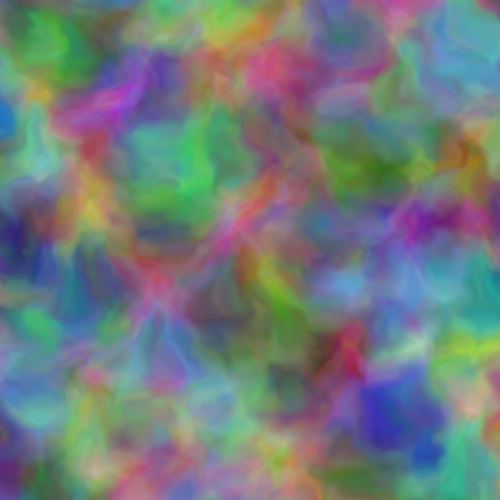

In [13]:
run(path, names, steps=200, step_size=0.005, octaves=range(-2,3), octave_scale=2.3)

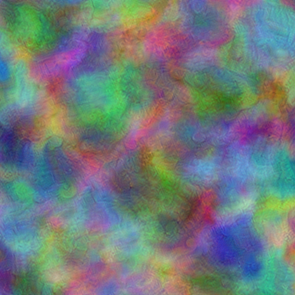

Octave -2, Step 50


KeyboardInterrupt: 

In [7]:
import random

i = 0
layers = base_model.layers
# Pick 10 random layers
for i in range(10):
  names = [random.choice(layers).name]
  run(path, names, steps=100, step_size=0.005, octaves=range(-2,2), octave_scale=1.3, project="random", i=i)
  i += 1